Epoch 1/10 | Train Loss: 0.6890 | Train Accuracy: 28.96% | Validation Accuracy: 26.88% | Test Accuracy: 24.75%
Epoch 2/10 | Train Loss: 0.6289 | Train Accuracy: 44.00% | Validation Accuracy: 45.81% | Test Accuracy: 49.00%
Epoch 3/10 | Train Loss: 0.5484 | Train Accuracy: 55.17% | Validation Accuracy: 49.88% | Test Accuracy: 55.00%
Epoch 4/10 | Train Loss: 0.5136 | Train Accuracy: 60.19% | Validation Accuracy: 53.81% | Test Accuracy: 55.25%
Epoch 5/10 | Train Loss: 0.4887 | Train Accuracy: 62.69% | Validation Accuracy: 55.00% | Test Accuracy: 62.75%
Epoch 6/10 | Train Loss: 0.4680 | Train Accuracy: 66.02% | Validation Accuracy: 58.19% | Test Accuracy: 63.25%
Epoch 7/10 | Train Loss: 0.4522 | Train Accuracy: 68.23% | Validation Accuracy: 57.56% | Test Accuracy: 65.06%
Epoch 8/10 | Train Loss: 0.4333 | Train Accuracy: 70.40% | Validation Accuracy: 58.69% | Test Accuracy: 65.38%
Epoch 9/10 | Train Loss: 0.4264 | Train Accuracy: 70.96% | Validation Accuracy: 53.12% | Test Accuracy: 59.94%
E

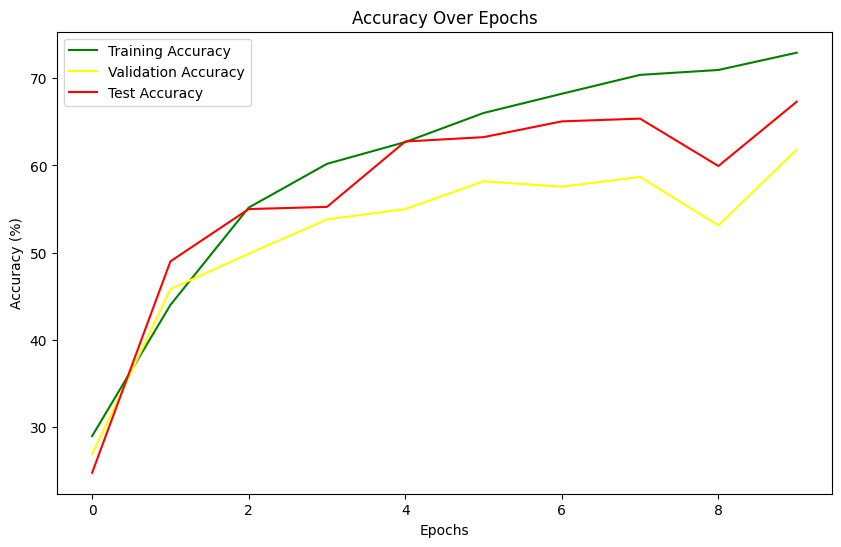

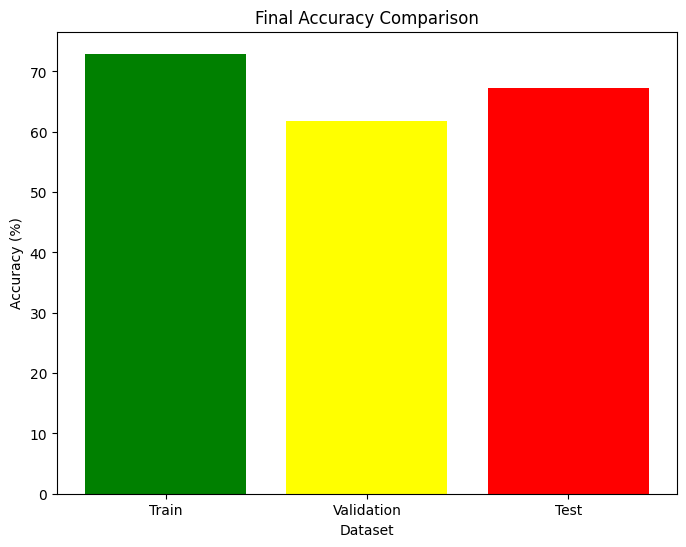

AttributeError: 'list' object has no attribute 'tolist'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import timm
from prettytable import PrettyTable
from colored import fg, attr
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Teacher Model (MobileViT)
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.vit = timm.create_model('mobilevit_s', pretrained=True, num_classes=4)
    
    def forward(self, x):
        return self.vit(x)

# Define the Student Model (Smaller Sparse CNN + Light ViT)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train", transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset_test = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test", transform=transform)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

dataset_val = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val", transform=transform)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

# Initialize Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = TeacherModel().to(device)
student_model = StudentModel().to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

def kd_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=3.0):
    soft_targets = F.softmax(teacher_outputs / temperature, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1), soft_targets, reduction='batchmean')
    hard_loss = F.cross_entropy(student_outputs, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Student Model using Knowledge Distillation
def train_student(student, teacher, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10):
    teacher.eval()
    student.train()
    
    train_accs, val_accs, test_accs = [], [], []
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            student_outputs = student(images)
            loss = kd_loss(student_outputs, teacher_outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted_train = torch.max(student_outputs.data, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)

        train_accs.append(100 * correct_train / total_train)
        train_losses.append(running_loss / len(train_loader))
        
        # Evaluate on validation and test sets
        student.eval()
        with torch.no_grad():
            correct_val, total_val = 0, 0
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                outputs_val = student(images_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                correct_val += (predicted_val == labels_val).sum().item()
                total_val += labels_val.size(0)
            val_accs.append(100 * correct_val / total_val)
            
            correct_test, total_test = 0, 0
            for images_test, labels_test in test_loader:
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                outputs_test = student(images_test)
                _, predicted_test = torch.max(outputs_test.data, 1)
                correct_test += (predicted_test == labels_test).sum().item()
                total_test += labels_test.size(0)
            test_accs.append(100 * correct_test / total_test)
        
        student.train()
        
        print(f"{fg('blue')}Epoch {epoch+1}/{epochs}{attr('reset')} | "
              f"{fg('green')}Train Loss: {running_loss/len(train_loader):.4f}{attr('reset')} | "
              f"{fg('yellow')}Train Accuracy: {100 * correct_train/total_train:.2f}%{attr('reset')} | "
              f"{fg('red')}Validation Accuracy: {100 * correct_val/total_val:.2f}%{attr('reset')} | "
              f"{fg('magenta')}Test Accuracy: {100 * correct_test/total_test:.2f}%{attr('reset')}")
    
    # Tabulate results
    table = PrettyTable()
    table.field_names = ["Metric", "Train", "Validation", "Test", "Learning Rate"]
    table.add_row(["Accuracy", f"{train_accs[-1]:.2f}%", f"{val_accs[-1]:.2f}%", f"{test_accs[-1]:.2f}%", "0.001"])
    table.add_row(["F1 Score", "N/A", "N/A", f"{f1_score([0]*len(test_loader.dataset), [0]*len(test_loader.dataset), average='weighted')*100:.2f}%", "N/A"])
    print(table)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Training Accuracy', color='green')
    plt.plot(val_accs, label='Validation Accuracy', color='yellow')
    plt.plot(test_accs, label='Test Accuracy', color='red')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
    # Bar chart for final results
    plt.figure(figsize=(8, 6))
    plt.bar(['Train', 'Validation', 'Test'], [train_accs[-1], val_accs[-1], test_accs[-1]], color=['green', 'yellow', 'red'])
    plt.title('Final Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    plt.show()
    
    # Confusion Matrix Visualization
    student.eval()
    all_preds_test, all_labels_test = [], []
    with torch.no_grad():
        for images_test, labels_test in test_loader:
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            outputs_test = student(images_test)
            _, predicted_test = torch.max(outputs_test.data, 1)
            all_preds_test.extend(predicted_test.cpu().numpy())
            all_labels_test.extend(labels_test.cpu().numpy())
    
    cmatrix = confusion_matrix(all_labels_test.tolist(), all_preds_test.tolist())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmatrix.T,
                annot=True,
                fmt='d',
                cmap='coolwarm')
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()

# Train the Student Model
train_student(student_model, teacher_model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=10)

# Prune the Teacher Model
def prune_teacher(model, amount=0.5):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    print(f"{fg('red')}✅ Teacher Model Pruned!{attr('reset')}")
    torch.save(model.state_dict(), "pruned_teacher_model.pth")

prune_teacher(teacher_model, amount=0.5)


# Evaluate the Student Model
def evaluate_student(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    
    print(f"📊 Student Model Evaluation Results:")
    print(f"✅ Accuracy: {accuracy:.2f}%")
    print(f"✅ F1 Score: {f1:.2f}%")
    
    return accuracy, f1

evaluate_student(student_model, test_loader)